In [1]:
import sys
import glob
import os
import re
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline


from itertools import chain
from scipy.optimize import curve_fit

# setting the colorscheme of the figures
COLOR = '#307890'
mpl.rcParams.update({'text.color' : COLOR,
                     'axes.labelcolor' : COLOR,
                     'xtick.color': COLOR,
                     'ytick.color': COLOR, 
                     'axes.edgecolor': COLOR})

# Preprocessing of the data

For usage of the ART, it is important that each replicate is assigned a single measurement value which represents how well the replicate performed. This value is often also referred to as the *performance measure*. For our perticular project, we decided to use the activity of the alpha-amylase produces by our machines as the performance measure. However, the output of our experiments is a time-series of absorbance measures and an OD measure for each sample. In this notebook, we go over the steps on how to go from these varying data types to a single alpha-amylase activity value. Note that only one 96 well plate can be processed at the time. If multiple 96 well plates are used, rerun this notebook for each well plate

## Step 1: Loading and structuring the data

Before any preprocessing can be done, the measurement data needs to be loaded into the python environment. For easy excess, we will store these measurments in a dataframe.

In [2]:
# Storing the current working directory for later usage
cwd = os.getcwd()
plate_name = 'AA 2-10' # Change this line in order to analyse a different 96 well plate
# Change into the correct working directory
data_dir = os.path.join(cwd,'data',plate_name)
os.chdir(data_dir)

In [3]:
# Extract the file names of all absorbance measurement files
abs_files = glob.glob('*.TXT')
abs_files.sort()
print(abs_files)

['19.02.TXT', '19.14.TXT', '19.19.TXT', '19.24.TXT', '19.29.TXT', '19.34.TXT', '19.39.TXT', '19.44.TXT', '19.49.TXT', '19.54.TXT', '19.59.TXT', '20.04.TXT', '20.09.TXT', '20.14.TXT', '21.12.TXT', 'error_2111.TXT']


Check wether all the listed files are intended to be used for the analysis. If there are any unwanted files, remove them using the cell below:

In [4]:
files_to_remove = ['error_2111.TXT'] # More files can be removed by adding more files to this list


for file in files_to_remove:
    abs_files.remove(file) 
print(abs_files)

['19.02.TXT', '19.14.TXT', '19.19.TXT', '19.24.TXT', '19.29.TXT', '19.34.TXT', '19.39.TXT', '19.44.TXT', '19.49.TXT', '19.54.TXT', '19.59.TXT', '20.04.TXT', '20.09.TXT', '20.14.TXT', '21.12.TXT']


In [5]:


# Creating a dataframe with time measurements and reference to the absorbance measure file
abs_df = pd.DataFrame(columns=['Hour', 'Minute', 'absolute_diff', 'File_name', 'abs_measurements'])
for i, file in enumerate(abs_files):
    ms_time = file.split('.')
    ms_time = [int(string) for string in ms_time[0:2]]
    if i == 0:
        time_diff = 0
    else:
        time_diff = (ms_time[0]-abs_df['Hour'][0])*60+(ms_time[1]-abs_df['Minute'][0])
    abs_measurement = pd.read_csv(file, header = None, sep=',')
    abs_measurement = abs_measurement.iloc[:, :-1] # Due to the output format of the plate reader, there is an extra column with empty values.
    abs_df.loc[i] = [ms_time[0], ms_time[1], time_diff, file, abs_measurement]
    print(np.shape(abs_df['abs_measurements'][i]))
print(abs_df)

(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
(8, 12)
   Hour Minute absolute_diff  File_name  \
0    19      2             0  19.02.TXT   
1    19     14            12  19.14.TXT   
2    19     19            17  19.19.TXT   
3    19     24            22  19.24.TXT   
4    19     29            27  19.29.TXT   
5    19     34            32  19.34.TXT   
6    19     39            37  19.39.TXT   
7    19     44            42  19.44.TXT   
8    19     49            47  19.49.TXT   
9    19     54            52  19.54.TXT   
10   19     59            57  19.59.TXT   
11   20      4            62  20.04.TXT   
12   20      9            67  20.09.TXT   
13   20     14            72  20.14.TXT   
14   21     12           130  21.12.TXT   

                                     abs_measurements  
0         0      1      2      3      4      5    ...  
1         0      1      2      3      4      5    ...  
2         0      1     

In [6]:
# Next up, is getting the arrangement of the samples on the plate
plate_arr = pd.read_csv('plate_arrangements.csv', sep=',', dtype = str)
plate_arr = plate_arr.iloc[:, 1:] # For easy navigation, the first column is removed
plate_arr.columns = [int(col_num)-1 for col_num in plate_arr.columns] # The previous step also means that the column names need to be updated

# The dataframe of the well locations is now in exactly the same shape as the dataframes used for storing the absorbance measures
print(np.shape(plate_arr))

print(plate_arr)
print(abs_df['abs_measurements'][0])


(8, 12)
    0    1      2      3      4      5       6       7    8    9    10   11
0  NaN  NaN    NaN    NaN    NaN    NaN     NaN     NaN  NaN  NaN  NaN  NaN
1  NaN  NaN    NaN    NaN    NaN    NaN     NaN     NaN  NaN  NaN  NaN  NaN
2  NaN  NaN  BLANK  BLANK  2nmol  2nmol  10nmol  10nmol  #34  NaN  NaN  NaN
3  #14  #14    #14    #15    #15    #15     #18     #18  #18  #20  #20  #20
4  #26  #26    #26    #27    #27    #27     #34     #34  NaN  #35  #35  #35
5  NaN  NaN    NaN    NaN    NaN    NaN     NaN     NaN  NaN  NaN  NaN  NaN
6  #06  #06    #06    #10    #10    #10     #11     #11  #11  #16  #16  #16
7  #21  #21    #21    NaN    NaN    NaN     NaN     NaN  NaN  NaN  NaN  NaN
      0      1      2      3      4      5      6      7      8      9   \
0  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
1  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
2  0.000  0.000  0.056  0.055  0.145  0.152  0.481  0.503  0.067  0.000   
3  0.066

In [7]:
# Extracting the unique values out of the plate arragements
samples = plate_arr.values.flatten()
samples = np.unique(samples.astype(str)) 
samples = np.delete(samples, np.where(samples == 'nan'))
print(f'Total number of unique samples in dataset: {len(samples)-3}') # Not including the baseline and standard measurements
# After extracting the unique values, it is possible to create a disctionary where each sample is matched with the corresponding absorbance measure
sample_dict = {}
for sample in samples:
    coordinates = np.array(np.where(plate_arr == sample)).T
    for i, coord in enumerate(coordinates):
        sample_name = sample + '_r' + str(i)
        sample_dict[sample_name] = [measurement[coord[1]][coord[0]] for measurement in abs_df['abs_measurements']]
print(sample_dict)

Total number of unique samples in dataset: 13
{'#06_r0': [0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065], '#06_r1': [0.067, 0.072, 0.075, 0.078, 0.08, 0.083, 0.085, 0.088, 0.09, 0.093, 0.095, 0.098, 0.101, 0.104, 0.133], '#06_r2': [0.065, 0.064, 0.064, 0.065, 0.064, 0.064, 0.064, 0.064, 0.064, 0.064, 0.064, 0.064, 0.064, 0.064, 0.065], '#10_r0': [0.07, 0.079, 0.084, 0.089, 0.093, 0.099, 0.105, 0.11, 0.116, 0.122, 0.127, 0.133, 0.139, 0.147, 0.214], '#10_r1': [0.068, 0.077, 0.082, 0.087, 0.092, 0.097, 0.103, 0.108, 0.114, 0.12, 0.126, 0.132, 0.138, 0.145, 0.213], '#10_r2': [0.088, 0.085, 0.087, 0.09, 0.093, 0.098, 0.103, 0.108, 0.114, 0.12, 0.126, 0.131, 0.137, 0.145, 0.214], '#11_r0': [0.066, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.068], '#11_r1': [0.067, 0.075, 0.078, 0.082, 0.085, 0.089, 0.092, 0.096, 0.099, 0.102, 0.106, 0.109, 0.112, 0.117, 0.154], '#11_r2': [0.066, 0.066,

In order to prevent confusion on what the current working directory is, set it back to the original working directory

In [8]:
os.chdir(cwd)

## Step 2: Checking the baseline absorbance 

The data currently stored in sample_dict cannot be used yet. The following data preprocessing steps need to be taken first:

1. Check the baseline absorbance and check whether the measured samples need to be accounted for a changing baseline
2. Remove any values above the 10nmol standard. 

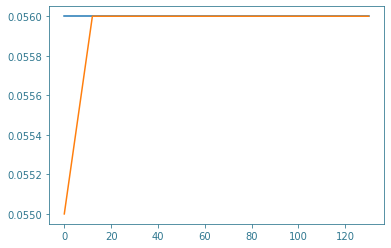

In [9]:
plt.plot(abs_df['absolute_diff'], sample_dict['BLANK_r0'])
plt.plot(abs_df['absolute_diff'], sample_dict['BLANK_r1'])

The plot shown above shows the standard of the blank wells. This should show a flat horizontal line. If they are not flat, this would be a possible indication that something went wrong with the measurements. Before moving on, please ensure these curves are in the correct shape, or if they are not, that the unusual shape can be explained. 

If the blank standard is at it should be, the next step is checking whether there are any datapoints that show an obsorbance which is higher than the 10nmol standard. Measurements above this standard generally no longer increase linearly with respect to time and are thus not represenative of the actual absorbance of the replicate. Measurements of the same replicate taken before the absorbance exceeded the standard can still be used as training data for the ART.

In [10]:
def correct_sample_by_standard(standard, sample, sample_name):
    rest = np.subtract(standard, sample)
    corrected_sample = sample
    for i, d_measurement in enumerate(rest):
        if d_measurement < 0:  # If d_measurement is less then 0, it means that absorbance measure in the sample has exceeded the 10 nmol standard
            corrected_sample = sample[:i]
            print(f'Shortening the time series of sample {sample_name} to length {len(corrected_sample)}')
            break
    return corrected_sample

avg_10nmol_standard = np.average([sample_dict['10nmol_r0'],sample_dict['10nmol_r1']], axis=0)

for sample, measurement in sample_dict.items():
    if ('#' in sample): # Only check the actual samples and skip the standard and baseline measurements
        sample_dict[sample] = correct_sample_by_standard(avg_10nmol_standard, measurement, sample)


Shortening the time series of sample #20_r1 to length 6


## Step 3: Determine alpha-amylase activity of each sample

The alpha-amylase activity of a sample is determined by the change in absorbance over time. This change in absorbance is linear with respect to time. Therefore, it is possible to fit a linear curve to each sample in order to abtain a function in the form of $absorbance = a*t+b$, where $a$ is the change in absorbance over time (i.e. the alpha-amylase activity), $t$ is the time and $b$ is some offset. 

Under perfect conditions, $b$ would be $0$ + the baseline absorbance. However, preparing the samples takes some time. This means that at the time of the first measurement, some samples already had the time to be activated by the reation buffer for about 15 minutes while others were only prepared one minute prior to measurements. This means that $b$ will be higher than the baseline for most of our samples.

For our analysis, the exact value of $b$ is irrelevant as the main interest lies within the change in absobance (i.e. $a$). The value of $b$ is only needed in order to fit the linear curve better to the datapoints. Once the curve has been fitted, the $a$ value is used and interpreted as the alpha-amylase activity of the sample. 

It is however important to first validate wether the absorbance measures indeed follow a linear pattern with respect to time. 

The absorbance measure of sample #06_r0:
[0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065, 0.065]
The absorbance measure of sample #06_r1:
[0.067, 0.072, 0.075, 0.078, 0.08, 0.083, 0.085, 0.088, 0.09, 0.093, 0.095, 0.098, 0.101, 0.104, 0.133]
The absorbance measure of sample #06_r2:
[0.065, 0.064, 0.064, 0.065, 0.064, 0.064, 0.064, 0.064, 0.064, 0.064, 0.064, 0.064, 0.064, 0.064, 0.065]
The absorbance measure of sample #10_r0:
[0.07, 0.079, 0.084, 0.089, 0.093, 0.099, 0.105, 0.11, 0.116, 0.122, 0.127, 0.133, 0.139, 0.147, 0.214]
The absorbance measure of sample #10_r1:
[0.068, 0.077, 0.082, 0.087, 0.092, 0.097, 0.103, 0.108, 0.114, 0.12, 0.126, 0.132, 0.138, 0.145, 0.213]
The absorbance measure of sample #10_r2:
[0.088, 0.085, 0.087, 0.09, 0.093, 0.098, 0.103, 0.108, 0.114, 0.12, 0.126, 0.131, 0.137, 0.145, 0.214]
The absorbance measure of sample #11_r0:
[0.066, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067, 0.067,

/home/user/.pyenv/versions/3.9.2/envs/test-3.9.2/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/user/.pyenv/versions/3.9.2/envs/test-3.9.2/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/user/.pyenv/versions/3.9.2/envs/test-3.9.2/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


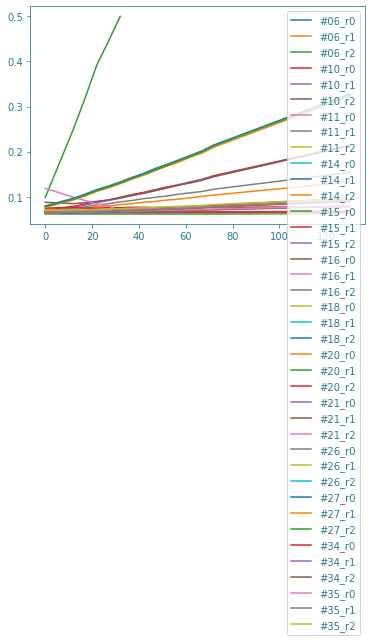

In [11]:

# Defining a linear curve
def linear_curve(x, a, b):
    return a * x + b

# Calculating R^2. For an explanation, see https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit
def determine_R2(xdata, ydata, popt):
    residuals = ydata - linear_curve(xdata, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

activity_dict={}
for sample in sample_dict:
    if ('#' in sample): # Only analize the samples and not the standards
        ydata = sample_dict[sample]
        xdata = abs_df['absolute_diff'][:len(ydata)] # As some samples might have been corrected for exceeding the standard, the length of the xdata might need to be shortened as well for that perticular sample
        popt, pcov = curve_fit(linear_curve, xdata, ydata)
        a, b = popt
        activity_dict[sample] = a # As explaine above, the slope of the curve is anagolous to the activity of the sample
        R_squared = determine_R2(xdata, ydata, popt)

        # The R^2 value represents how well the y-value can be explained by the x-value by some function f(). In this case,
        # the f() function is a first order polynomial (i.e. a linear curve) in the form of f(x)=y=a*x+b. The downside of using 
        # the R^2 value for representing the fit to a linear curve, is that is there is no slope (i.e. a=0), the R^2 value is 0
        # as well. Therefore, all absorbance measures that have a R^2 value of less than 0.95 need to be manually verified on whether
        # they are in fact linear curves. 
        if R_squared < 1: 
            plt.plot(xdata, ydata, label=sample)
            #print(f'R^2 value of sample {sample}: {R_squared}')
            print(f'The absorbance measure of sample {sample}:')
            print(ydata)
        else:
            print(f'Sample {sample} fits the linear curve with an R^2 of {R_squared}')
plt.legend()

Based on the figure created in the cell above, it should be possible to locate any replicate that does not show the expected linear behavior. In order to exclude this replicate, along with other replicates of the same sample, enter the name of this sample in the in the cell below

In [12]:

samples_to_exclude = ['#21', '#17', '#40', '#43', '#64', '#57'] # for example: ['#26', '#17'] in order to exclude all replicates of samples 26 and 17


print(f'Samples in dictionary before removal: {activity_dict.keys()}')
for sample in samples_to_exclude:
    activity_dict = dict(filter(lambda elem: sample not in elem[0], activity_dict.items()))
print(f'Samples in dictionary after removal: {activity_dict.keys()}')

Samples in dictionary before removal: dict_keys(['#06_r0', '#06_r1', '#06_r2', '#10_r0', '#10_r1', '#10_r2', '#11_r0', '#11_r1', '#11_r2', '#14_r0', '#14_r1', '#14_r2', '#15_r0', '#15_r1', '#15_r2', '#16_r0', '#16_r1', '#16_r2', '#18_r0', '#18_r1', '#18_r2', '#20_r0', '#20_r1', '#20_r2', '#21_r0', '#21_r1', '#21_r2', '#26_r0', '#26_r1', '#26_r2', '#27_r0', '#27_r1', '#27_r2', '#34_r0', '#34_r1', '#34_r2', '#35_r0', '#35_r1', '#35_r2'])
Samples in dictionary after removal: dict_keys(['#06_r0', '#06_r1', '#06_r2', '#10_r0', '#10_r1', '#10_r2', '#11_r0', '#11_r1', '#11_r2', '#14_r0', '#14_r1', '#14_r2', '#15_r0', '#15_r1', '#15_r2', '#16_r0', '#16_r1', '#16_r2', '#18_r0', '#18_r1', '#18_r2', '#20_r0', '#20_r1', '#20_r2', '#26_r0', '#26_r1', '#26_r2', '#27_r0', '#27_r1', '#27_r2', '#34_r0', '#34_r1', '#34_r2', '#35_r0', '#35_r1', '#35_r2'])


{'#06_r0': -2.1811441541785825e-12, '#06_r1': 0.0005126512546344651, '#06_r2': 1.207164114730796e-06, '#10_r0': 0.0011271065464292227, '#10_r1': 0.0011355614742202882, '#10_r2': 0.0010378052614328226, '#11_r0': 9.341137663150845e-06, '#11_r1': 0.0006741044482238937, '#11_r2': 2.42869379607491e-06, '#14_r0': -3.238260443113404e-06, '#14_r1': 2.8646131055819655e-06, '#14_r2': -4.4808722228077e-05, '#15_r0': 6.102879451060657e-06, '#15_r1': 2.324266580433618e-05, '#15_r2': 4.799908964598643e-06, '#16_r0': 1.1688396460083407e-05, '#16_r1': 1.4926656297170724e-05, '#16_r2': -2.1809221095736575e-12, '#18_r0': -1.657454536421516e-06, '#18_r1': -3.238260443113406e-06, '#18_r2': 6.102878829660443e-06, '#20_r0': 3.2382619179281853e-06, '#20_r1': 0.012709693887146463, '#20_r2': -2.1811441541785825e-12, '#26_r0': 0.00020200810534360224, '#26_r1': 0.00018822633357302022, '#26_r2': 0.00021039117780073771, '#27_r0': 0.0019363940337913058, '#27_r1': 0.0019225451960867706, '#27_r2': 0.00193625511338730

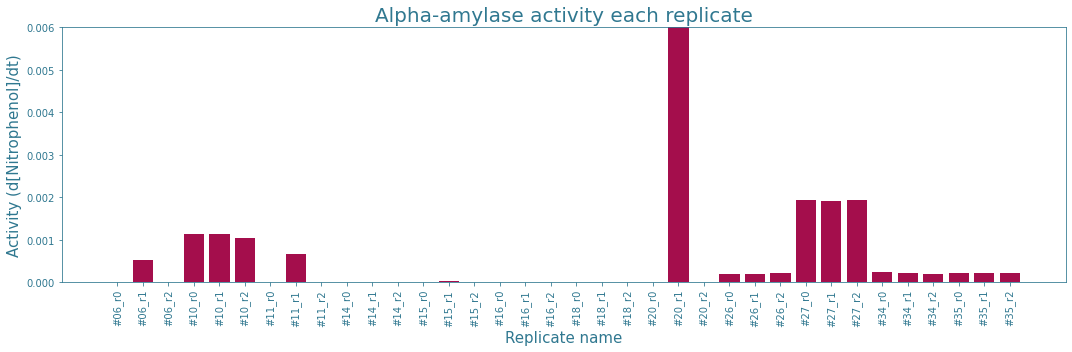

In [13]:

print(activity_dict) # Printing the raw data in to see the exact values.
fig, ax = plt.subplots(figsize=(15, 5))
ax.tick_params(axis='x', rotation=90)
ax.set_title('Alpha-amylase activity each replicate',fontsize=20)
ax.set_ylabel('Activity (d[Nitrophenol]/dt)', fontsize=15)
ax.set_ylim([0,0.006])
ax.set_xlabel('Replicate name', fontsize=15)
plt.bar(activity_dict.keys(), activity_dict.values(), color='#A40E4C')
fig.tight_layout()
fig.savefig('./figures/activity_'+plate_name+'.pdf', transparent=True)
fig.savefig('./figures/activity_'+plate_name+'.png', transparent=True)
# plt.xticks(rotation=90)

It is possible that some replicates show a completely different value then the other replicates of the same sample. This absolutely fine. The actual outlier detection is handled by the ART, so these 'weird' values can remain in the input data for the ART.

## Step 4: Decrease the order of magnitude of the variance within the activity measures

Most activity values of the samples that show at least some activity are in between the range of $1*10^{-5}$ and $1*10^{-4}$. While there is already an order of magnitude between these values, some values go as high $6*10^{-3}$. This means that there is a difference of more than two orders of magnitude between the lowest and the highest activity measures. The difference in the lower activity value ranges are therefore close to non-existant in comparison to the total spread of activity values. These differences in lower activity values are however important when training the ART. If most activity measures are considered to be 0, there is not much data to train on. Therefore, a way is needed to project the activity measures which can vary multiple orders of magnitude onto data points which vary only on a single order of magnitude. Taking the natural logarithm is one of the ways of achieving this.


A downside of taking the natural logarithm is that values very close to 0 are transformed dispropotionately large negative numbers. However, values close very close to 0 are likely to not show any activity at all. Any variation between these numbers is likely to be caused by a minor measuring error. Therefore, a cutt-off value is needed to prevent the ART from trying to learn these measuring errors.

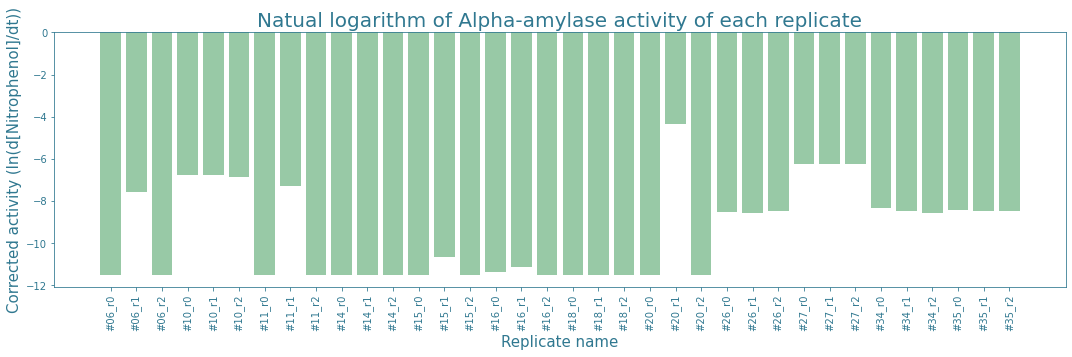

In [14]:
cut_off = 0.00001

for key, value in activity_dict.items():
    if value < cut_off:
        activity_dict[key] = cut_off

zipped_corrected_activities = zip(activity_dict.keys(), np.log(list(activity_dict.values())))
corrected_activity_dict = dict(zipped_corrected_activities)

fig, ax = plt.subplots(figsize=(15, 5))
ax.tick_params(axis='x', rotation=90)
ax.set_title('Natual logarithm of Alpha-amylase activity of each replicate',fontsize=20)
ax.set_ylabel('Corrected activity (ln(d[Nitrophenol]/dt))', fontsize=15)
ax.set_xlabel('Replicate name', fontsize=15)
plt.bar(corrected_activity_dict.keys(), corrected_activity_dict.values(), color='#98C9A6')
fig.tight_layout()
fig.savefig('./figures/ln(activity)_'+plate_name+'.pdf', transparent=True)
fig.savefig('./figures/ln(activity)_'+plate_name+'.png', transparent=True)

Instead of having values that vary several order of magnitude, all values should now be somewhere between -5 and -12

## Step 5: Match the strain name with the strain, promoter, secretion peptide and gene combination and export the results

Once the activity of each sample has been determined, this activity needs to be matched to combination of parts used for creating the sample. The end result is a file in which can be directly used by the ART pipeline.  

In [15]:
results = pd.read_csv('Sample_list.csv', sep=',') # load in the file contianing the link of the sample name to the various parts

for sample in activity_dict:
    line_name, replicate = sample.split('_')
    print(line_name)
    # Adding the measured and corrected activity to the results
    results.loc[(results['Line Name']==line_name) & (results['Replicate']==replicate), 'Corrected activity'] = corrected_activity_dict[sample]
    results.loc[(results['Line Name']==line_name) & (results['Replicate']==replicate), 'Activity'] = activity_dict[sample]
    print(f'Updated entry of line {line_name}')
    print(results.loc[(results['Line Name']==line_name) & (results['Replicate']==replicate)])
# Write the results into the original file
results.to_csv('Sample_list.csv', sep=',', index=False) 

#06
Updated entry of line #06
   Line Name Replicate Activity  str_idx  pro_idx  sec_idx  gen_idx  \
15       #06        r0  0.00001        2       11       17       19   

    Corrected activity  
15          -11.512925  
#06
Updated entry of line #06
   Line Name Replicate  Activity  str_idx  pro_idx  sec_idx  gen_idx  \
16       #06        r1  0.000513        2       11       17       19   

    Corrected activity  
16           -7.575915  
#06
Updated entry of line #06
   Line Name Replicate Activity  str_idx  pro_idx  sec_idx  gen_idx  \
17       #06        r2  0.00001        2       11       17       19   

    Corrected activity  
17          -11.512925  
#10
Updated entry of line #10
   Line Name Replicate  Activity  str_idx  pro_idx  sec_idx  gen_idx  \
27       #10        r0  0.001127        2        8       16       22   

    Corrected activity  
27           -6.788102  
#10
Updated entry of line #10
   Line Name Replicate  Activity  str_idx  pro_idx  sec_idx  gen_idx  \
28